In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from SMILE import SMILE
from SMILE.SMILE import SMILE_trainer

import torch

import umap
import anndata
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

In [2]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)
        m.bias.data.zero_()

In [3]:
h4c_file = "Zeisel.h5"
adata = sc.read_h5ad(h4c_file)

X = adata.X
scaler = StandardScaler()
X = scaler.fit_transform(X)

cells = adata.obs['cell'].values.tolist()
cells = np.array(cells)

In [4]:
X_all_tensor = torch.tensor(X).float()
clf_out = 25
net = SMILE.SMILE(input_dim=X.shape[1],clf_out=clf_out)
net.apply(weights_init)

SMILE(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (clf): Sequential(
    (0): Linear(in_features=128, out_features=25, bias=True)
    (1): Softmax(dim=1)
  )
  (feature): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
  )
)

In [5]:
SMILE_trainer(X,net)

Total loss: 45.7226
Total loss: 31.5527
Total loss: 25.1407
Total loss: 20.3647
Total loss: 16.4917


... storing 'CellType' as categorical


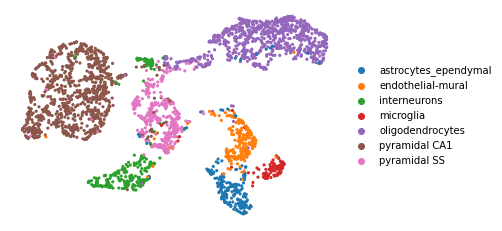

In [6]:
net.to(torch.device("cpu"))
y_pred = net.encoder(X_all_tensor)
y_pred = torch.Tensor.cpu(y_pred).detach().numpy()

embedding = umap.UMAP(n_neighbors=10, min_dist=0.25, n_components=2,
                        metric="euclidean").fit_transform(y_pred)
embedding = pd.DataFrame(embedding)
embedding.columns=['UMAP1','UMAP2']
embedding["Cluster"]=cells
adata.obsm['X_umap']=embedding.iloc[:,:2].values
adata.obs['CellType']=cells
sc.pl.umap(adata, color='CellType', title='', frameon=False)